# Project 5: Computer Vision and Machine Learning
## Vehicle Detection and Tracking

### Objective
An important function of an autonomous vehicle is to be able to detect and track vehicles around it. For this project, the objective is to explore a method of detecting vehicles using a linear support vector machine (SVM) and write a software pipeline to detect vehicles on a continous video stream.

### Overview
The following are the steps taken to build a vehicle detection pipeline:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled set of images 
2. Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector. 
3. Normalize features and randomize a selection for training and testing
4. Train SVM Classifier
5. Implement a sliding-window technique and use the trained classifier to search for vehicles in image frames
6. Run the frame processing pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles
7. Estimate and draw a bounding box for vehicles detected on the video stream from the heat map

### Dataset 

The labeled data used to train and develop the classfier to detect vehicles comes from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html) dataset, the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/) dataset, and examples extracted from the project video (`project_video.mp4`). The labeled data is divided into two main sets:
* Data that contains example of [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)
* Data that contains examples of [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)

### Notebook Summary
This IPython notebook was used to develop the algorithm to detect and track vehicles in a video stream. The notebook is divided into four major parts:
1. **Data exploration**: Study dataset composition
2. **Feature engineering**: Select and optimize features to train the classifier
3. **Building an SVM classifier**: Train classifier - linear support vector machine
4. **Vehicle Tracking**: Overview of the vehicle detection algorithm and pipeline 

In [116]:
import pickle
import os
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
%matplotlib inline

In [2]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [3]:
def read_image(file_name):
    """Function reads image based on file type""" 
    file_type = file_name[file_name.index('.')+1:]
    if file_type == 'jpg':
        image = mpimg.imread(file_name)
    elif file_type == 'png':
        image = (mpimg.imread(file_name)*255).astype('uint8')
    return image

---
## Part 1: Data Exploration

##### Load image file names from vehicle and non-vehicle datasets

In [4]:
def get_fnames_from_dirs(root_folder, extension='.png'):
    """ Loads images into a numpy array from a list of
        directories"""
    # Get all directories in the root folder
    dir_list = os.listdir(root_folder)[1:]
    
    # Load image file names from all directories
    image_fnames = []
    for dir in dir_list:
        image_fnames = image_fnames + glob.glob(root_folder + '/' + dir + "/***" + extension) 
    return image_fnames

In [5]:
# Load all file names for vehicle and non-vehicle images
vehicle_fnames = get_fnames_from_dirs("vehicles")
non_vehicle_fnames = get_fnames_from_dirs("non-vehicles")

##### Data Summary

In [6]:
def data_summary(car_list, notcar_list):
    """ function to returns characteristics of the dataset in a dictionary"""
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    data_dict["image_shape"] = cv2.imread(car_list[0]).shape
    data_dict["data_type"] = cv2.imread(car_list[0]).dtype
    return data_dict

In [7]:
data_info = data_summary(vehicle_fnames, non_vehicle_fnames)

print('Number of samples containing vehicles: ', data_info["n_cars"])
print('Number of samples with NO vehicles: ', data_info["n_notcars"])
print('Size of images: ', data_info["image_shape"])
print('Image data type: ', data_info["data_type"])

Number of samples containing vehicles:  8792
Number of samples with NO vehicles:  8968
Size of images:  (64, 64, 3)
Image data type:  uint8


Overall the data set contails 17k+ samples divided evenly between samples containing vehicles and non-vehicle images. A balanced data set like this one is neccesary to train a high accuracy classifier

#### Sample Images

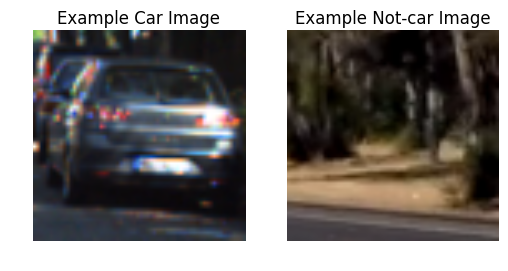

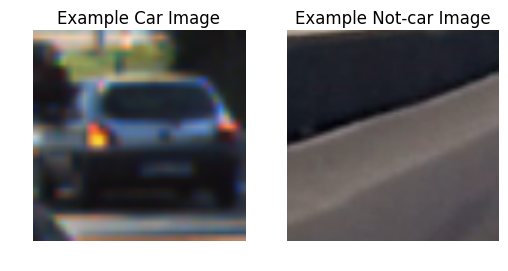

In [8]:
for i in range(0,2):
    car_ind = np.random.randint(0, len(vehicle_fnames))
    notcar_ind = np.random.randint(0, len(non_vehicle_fnames))
    
    # Read in car / not-car images
    car_image = read_image(vehicle_fnames[car_ind])
    notcar_image = read_image(non_vehicle_fnames[notcar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.axis("off")
    plt.title('Example Not-car Image')

---
## Part 2: Feature Extraction/Engineering
A crucial step to having a high performance classifier is selecting the right features for training that result in high accuracy and speed. For each image in the labeled dataset a feature vector was constructed to train an SVM classifier. The selected features include:

1. ** Raw Pixel Values with Spatial Binning**: Raw pixel data of a reduced resolution image. Even with reduced resolution key structure information is kept
2. **Color Histogram**: Extract information for color distribution (shape invariance) 
3. **HOG - Histogram of Gradients**: Extract information related to shape structure

___
### Feature 1: Raw Pixel Values with Spatial Binning
The first component of the feature vector of each image in the labeled dataset wil be raw pixel information. An important observation with objects such as cars is that they have high color saturation. It is possible to maximize the information extracted from these pixels by selecting the appropriate color space. With the correct selection of color space it is possible to identify clusters of pixels that can help us differentiate cars from non car objects. After testing several color spaces (RGB, HLS, HSV, YUV, etc), YCbCr showed clearest clusters with the least of amount of noise. 3D visualization of pixel values in YCbCr Space can be seen below for vehicle and non-vehicle images.

#### Vehicle: Raw Pixel Values in 3D space in YCbCr
<img src='readme_images/car_ycrcb_3d.png' style="width:400px;height:400px;">

#### Non-Vehicle: Raw in 3D Space in YCbCr
<img src='readme_images/notcar_ycrcb_3d.png' style="width:400px;height:400px;">


While it could be data intensive to include three color channels of a full resolution image, you can perform **spatial binning** on an image and still retain enough information to help in finding vehicles.
A convenient function for scaling down the resolution of an image is OpenCV's `cv2.resize()`. we will resize images from 64 x 64 to 32 x32.

In [9]:
def spatial_bin(image, new_size=(32,32)):
    features = cv2.resize(image, new_size).ravel()
    return features

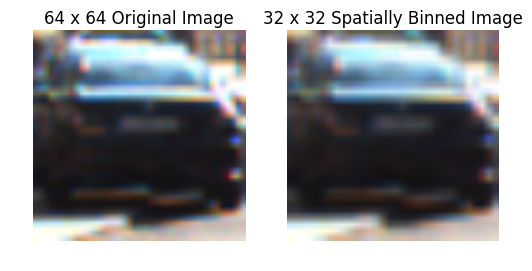

In [10]:
# Spatially bin a sample image
orig_image = np.random.choice(vehicle_fnames, 1)[0]
orig_image = read_image(orig_image)
spa_image = cv2.resize(orig_image ,(32,32))

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(orig_image)
plt.title('64 x 64 Original Image')
plt.axis("off")
plt.subplot(122)
plt.imshow(spa_image)
plt.axis("off")
plt.title('32 x 32 Spatially Binned Image')

#### Feature Vector Length

In [11]:
print("Spatial binning of color feature vector size: ", len(spatial_bin(orig_image)))

Spatial binning of color feature vector size:  3072


***
###  Feature 2: Color Histogram
The distribution of pixels/color across channels can provide shape invariant information about objects in an image.
Just like the previous feature, by picking the right color space we can maximize the extracted information. The color histogram from vehicle and non-vehicle images was computed accross several color spaces. Color Spaces that provide information about color saturation seemed to provide the best signatures overall; therefore, YCbCr was selected to keep the feature extraction pipeline simple.

In [12]:
def color_hist(img, nbins=32, bins_range=(0, 256), hist_channels='ALL', vis=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    if vis == True:
        # Generate bin centers for plotting
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features
    else:
        # Return color histogram features of the specified amount of channels
        if hist_channels == 1:
            hist_features = channel1_hist[0] 
        elif hist_channels == 2:
            hist_features = np.concatenate((channel1_hist[0], channel2_hist[0]))
        elif hist_channels == "ALL":
            hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0])) 
        return hist_features

### Test Different Color Spaces
Final Selection **YCrCb** Color Space

#### Vehicle Image Histograms

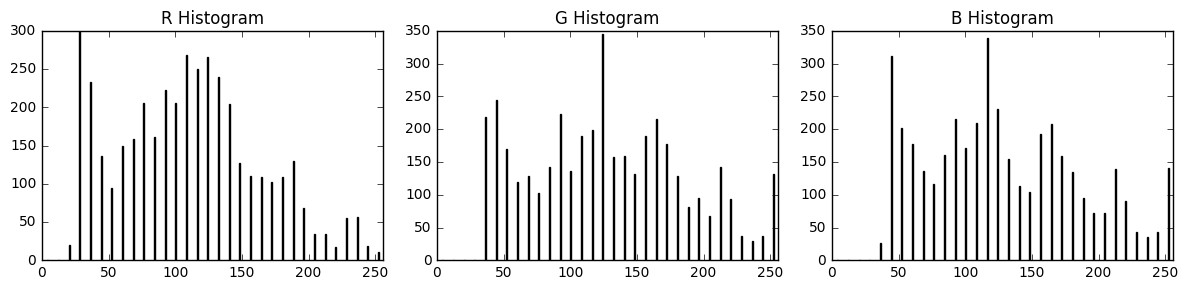

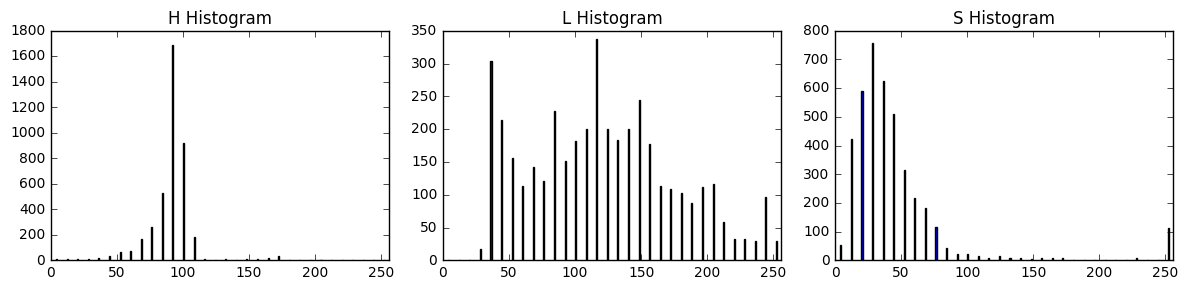

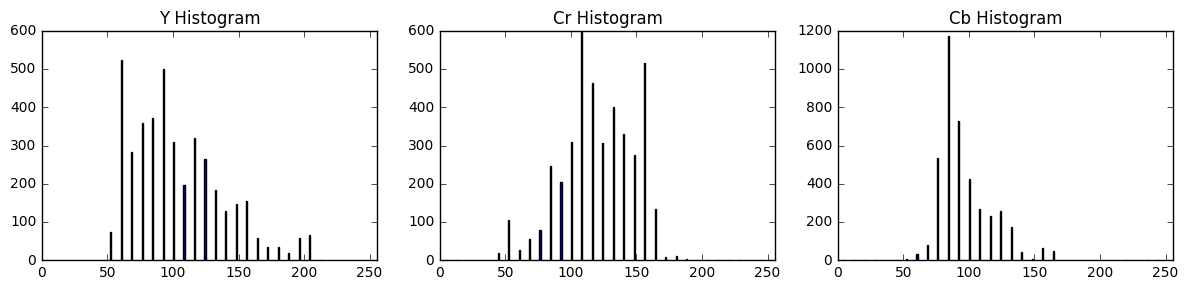

In [13]:
car_image= np.random.choice(vehicle_fnames, 1)[0]
car_image = read_image(car_image)
# List of color spaces to test the histogram feature
c_spaces = [('R', 'G', 'B'), ('H', 'L', 'S'), ('Y', 'Cr', 'Cb')]
for cspace in c_spaces:    
    cspace_str = "".join(cspace)
    # Change color space
    if cspace_str != "RGB":
        car_image = cv2.cvtColor(car_image, eval("cv2.COLOR_RGB2" + cspace_str))
    # compute color historgram
    rh, gh, bh, bincen, feature_vec = color_hist(car_image, nbins=32, bins_range=(0, 256), vis=True)

    # Plot a figure with all three bar charts
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title(cspace[0] +' Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title(cspace[1] +' Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title(cspace[2] + ' Histogram')
    fig.tight_layout()

##### Non-Vehicle Histograms

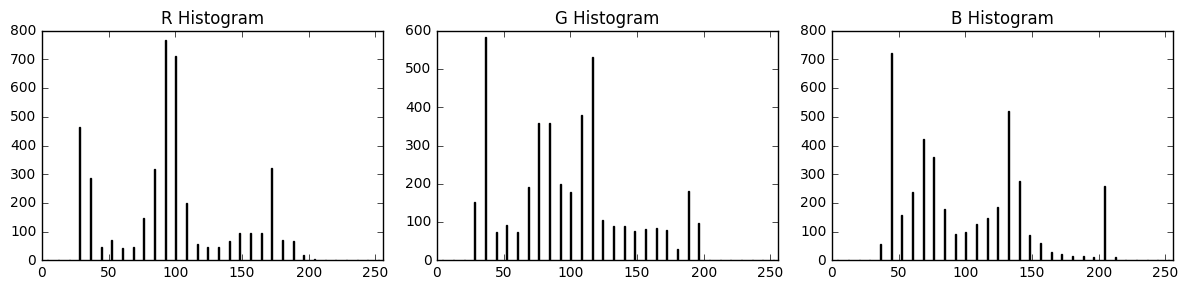

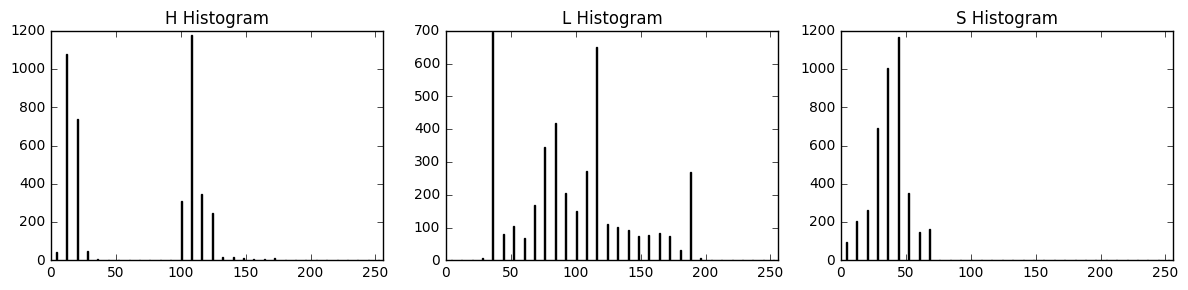

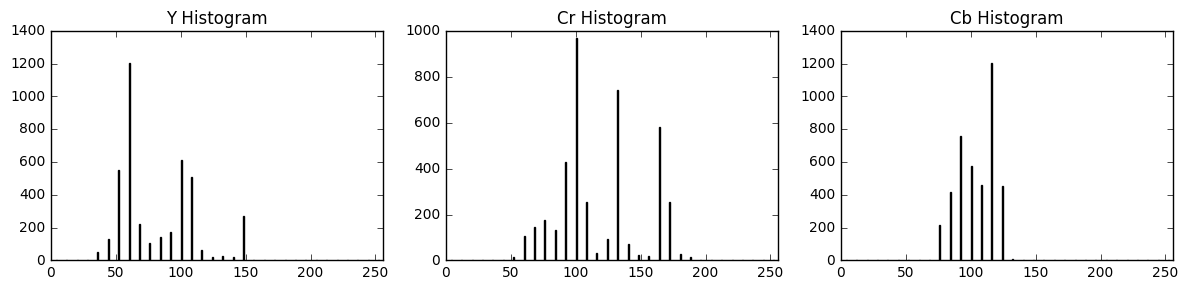

In [14]:
notcar_image= np.random.choice(non_vehicle_fnames, 1)[0]
notcar_image = read_image(notcar_image)
# List of color spaces to test the histogram feature
c_spaces = [('R', 'G', 'B'), ('H', 'L', 'S'), ('Y', 'Cr', 'Cb')]
for cspace in c_spaces:    
    cspace_str = "".join(cspace)
    # Change color space
    if cspace_str != "RGB":
        notcar_image = cv2.cvtColor(notcar_image, eval("cv2.COLOR_RGB2" + cspace_str))
    # compute color historgram
    rh, gh, bh, bincen, feature_vec = color_hist(notcar_image, nbins=32, bins_range=(0,256), vis=True)

    # Plot a figure with all three bar charts
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title(cspace[0] +' Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title(cspace[1] +' Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title(cspace[2] + ' Histogram')
    fig.tight_layout()

#### Feature Vector Length

In [15]:
notcar_image= np.random.choice(non_vehicle_fnames, 1)[0]
notcar_image = read_image(notcar_image)
feature_vec = color_hist(notcar_image, nbins=32, bins_range=(0,256))

print("Color histogram feature vector size: ", len(feature_vec))

Color histogram feature vector size:  96


### Feature 3: HOG - Histogram Oriented Gradients
Histograms of oriented gradients provide key shape information about object within images. The HOG features of images containing vehicle and non-vehicle objects were computed for the 3-channels of the YCbCr color space. The parameters used to to extract HOG features are listed below.

**Selected Parameters**
* orientation bins: 9
* pixels per cell: 8 x 8
* cells pers block: 2 x 2
* Hog Channels: 3

In [16]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

###### Vehicle HOG

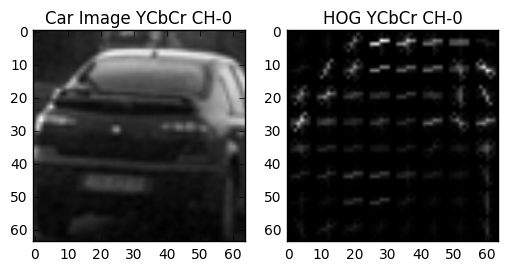

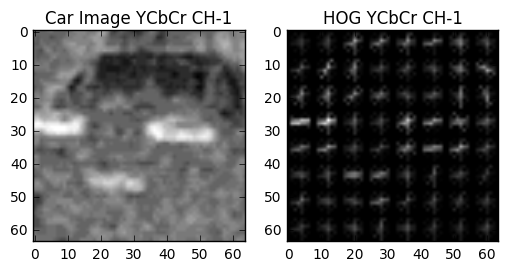

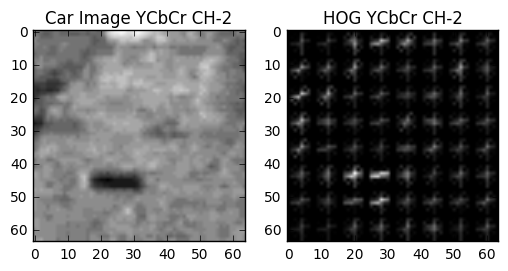

In [17]:
# Hog Parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Load Image
car_image= np.random.choice(vehicle_fnames, 1)[0]
car_image = read_image(car_image)
car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)


# Get hog features and visualization
for i in range(0,3):
    features, hog_img = get_hog_features(car_image[:,:,i], orient, pix_per_cell, cell_per_block, vis=True)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image[:,:,i], cmap='gray')
    plt.title('Car Image YCbCr CH-'+ str(i) )
    plt.subplot(122)
    plt.imshow(hog_img, cmap='gray')
    plt.title('HOG YCbCr CH-'+ str(i) )

In [61]:
features, hog_img = get_hog_features(car_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

#### Non-Vehicle HOG

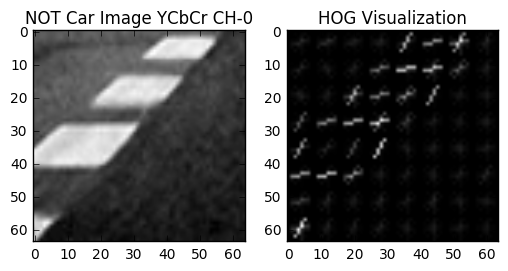

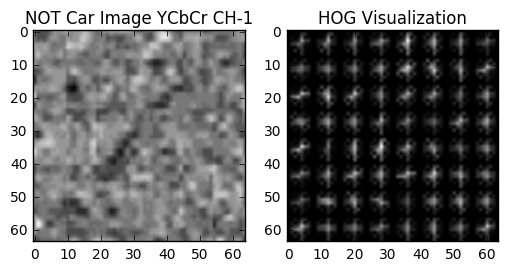

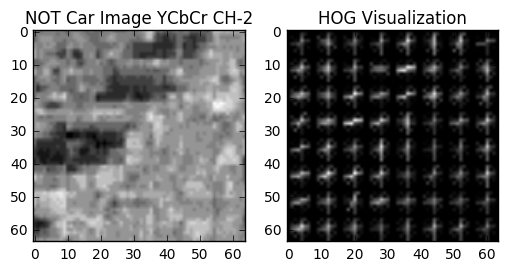

In [19]:
# Load Image
car_image= np.random.choice(non_vehicle_fnames, 1)[0]
car_image = read_image(car_image)
car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)

# Get hog features and visualization
for i in range(0,3):
    features, hog_img = get_hog_features(car_image[:,:,i], orient, pix_per_cell, cell_per_block, vis=True)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image[:,:,i], cmap='gray')
    plt.title('NOT Car Image YCbCr CH-'+ str(i))
    plt.subplot(122)
    plt.imshow(hog_img, cmap='gray')
    plt.title('HOG Visualization')

#### Feature Vector Length

In [20]:
print("HOG feature vector size per channel: ", len(features))

HOG feature vector size per channel:  1764


---
### Extract All Features into a Single Feature Vector

After all the features are extracted, they are concatanated together in a feature vector. Each image has its own vector and are used to train a classifier.

* ** Feature from spatial binning**: 3017
* **Features from Color Histogram** : 96
* **Features from HOG from 3 channels**: 5292

* **Total # of Features**: 8460

#### Define a function to extract  features from an image

In [98]:
def extract_image_features(image, cspace='RGB', spatial_size=(32,32), hist_bins=32, hist_range=(0,256), 
                     hist_channels=2, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        cv2_space = eval("cv2.COLOR_RGB2" + cspace)
        feature_image = cv2.cvtColor(image, cv2_space)
    else: feature_image = np.copy(image)      

    # Apply spatial_bin() to get spatial color features
    spatial_features = spatial_bin(feature_image, new_size=spatial_size)
        
    # Apply color_hist() to get histogram features
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range, hist_channels=hist_channels)
    
    # Apply get_hog_features() to obtain HOG features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    
    # Concatanate all features into a single vector
    features = np.concatenate((spatial_features, hist_features, hog_features))
    return features

#### Define a function to extract  features from a list of images

In [99]:
def extract_features_from_files(image_files, cspace='RGB', spatial_size=(32,32), hist_bins=32, hist_range=(0, 256), 
                     hist_channels=3, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """pydoc"""
    features = []
    # Extract features from each image file and append to a feature list
    for file in image_files:
        image = read_image(file)
        image_features = extract_image_features(image, cspace, spatial_size, hist_bins, hist_range, 
                     hist_channels, orient, pix_per_cell, cell_per_block, hog_channel)
        features.append(image_features)
    return features

---
## Part 3: Build an SVM Classifier

Now that we have extracted all the feature vectors from the labeled data we can train a Support Vector Machine to classify and detect vehicles in images.

#### Load All File Names for Vehicle and Non-Vehicle Image Datasets

In [23]:
# Load all file names
vehicle_fnames = get_fnames_from_dirs("vehicles")
non_vehicle_fnames = get_fnames_from_dirs("non-vehicles")

#### Extract Features from Vehicle and Non-Vehicle Image Datasets

In [24]:
# Feature Extraction Parameters
spatial = 32           # 32x32
hist_bins = 32
hist_range = (0,256)
hist_channels= 'ALL'   # Can be 1, 2, or "ALL"
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8       # 8x8
cell_per_block = 2     # 2x2
hog_channel = 'ALL'    # Can be 0, 1, 2, or "ALL"

In [100]:
vehicle_features = extract_features_from_files(vehicle_fnames, color_space,(spatial, spatial), hist_bins, hist_range, 
                                               hist_channels, orient, pix_per_cell, cell_per_block, hog_channel)

non_vehicle_features = extract_features_from_files(non_vehicle_fnames, color_space,(spatial, spatial), hist_bins,
                                        hist_range, hist_channels, orient, pix_per_cell, cell_per_block, hog_channel)

In [101]:
np.vstack((vehicle_features, non_vehicle_features)).shape

(17760, 8460)

In [27]:
# Stack features
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)

# Normalize features - Scale Features
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Create labels
Y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
               
# Shuffle and train-test split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=rand_state)

#### Train and Validate SVM

In [33]:
# Create classifier
svc = LinearSVC()

# Train SVM
svc.fit(X_train, y_train)

# Print scores i.e classification performance
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

# Save model in a pickle file 
svm_pickle = {}
svm_pickle["svc"] = svc
svm_pickle["scalar"] = X_scaler

pickle.dump(svm_pickle, open("svm_pickle.p", "wb" ))

Test Accuracy of SVC =  0.993806306306


---
## Part 4: Vehicle Detection
With a trained SVM classifier and a feature extractor engine, we can search images for cars of multiple sizes, detect them and track them and draw bounding boxez around them. To achieve that, the following three steps were taken:

1. Slide window search
2. Classify the contents of the resulting from slide window search
3. Construct a Heatmap of detections to remove outliers(false detections) and estimate a bounding box around each detected vehicles

In [29]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Step 1: Sliding Window Search
Slide window search takes a patch of an image (**The patch is the region of the image where vehicles are expected to be seen**) and divides it into overlapping fixed sized windows. The coordinates of each window/box is recorded and will be later run against an SVM to check whether a vehicle is present inside that box.

**Parameters**
1. `x_start_stop`: X start and stop positions for the region of interest
2. `y_start_stop`: Y start and stop positions for the region of interest 
1. `xy_window`: Size of the window/box of interest
2. `xy_overlap`: Percentage of overalap between windows

**Selected Parameters**

1. `x_start_stop` = [`None, None`]
2. `y_start_stop` = [380, 625] 
3. `xy_window` = (80, 80) 
4. `xy_overlap` = (0.75, 0.75)

In [34]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    # Loop through finding x and y window positions
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

#### Slide Window Search Visualization

Number of windows to be searched:  549


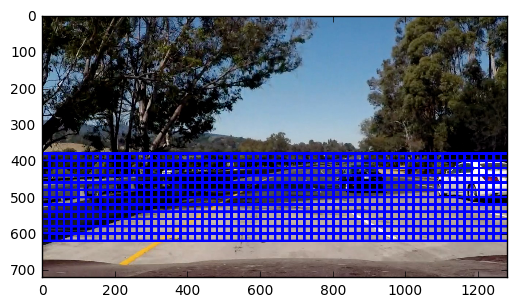

In [185]:
# Load test images
PATH = "test_images/"
test_images = os.listdir("test_images/")[1:]
test_image = read_image(PATH + test_images[4])

# Selected Slide Window Search Parameters
x_start_stop = [None, None]
y_start_stop = [380, 625] 
xy_window = (80, 80) 
xy_overlap=(0.75, 0.75)

# Slide Window 
window_boxes = slide_window(test_image, x_start_stop, y_start_stop, xy_window, xy_overlap)
print("Number of windows to be searched: ", len(window_boxes))
plt.imshow(draw_boxes(test_image, window_boxes))

Above is a representation of the overlapping windows across the selected region of interest.

###  Step 2:  Extract and Classify
Now that we have coordinates for each window, we can search through each and extract revelant features to run them through the SVM classifier to determine whether a vehicle is present in it. A window with a vehicle in it is called a hot window. Coordinates of each hot window will be recorded to build a heatmap of detections.

In [112]:
def search_for_cars(image, window_boxes, svc, scaler, cspace='RGB', spatial_size=(32, 32), hist_bins=32, 
                   hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):

    # Extract all window boxes where a vehicle was detected
    hot_windows = []
    for box in window_boxes: 
        
        # Extract image patch from original image and resize to 64 x 64
        # Images used to train the model were all of size 64 by 64.
        # It is imperative to extract the same amount of features so that the classifier works correctly
        image_patch = cv2.resize(image[box[0][1]:box[1][1], box[0][0]:box[1][0]], (64, 64))      
        
        # Extract features from current image in frame
        features = extract_image_features(image_patch, cspace, spatial_size, hist_bins, hist_range, 
                     hist_channels, orient, pix_per_cell, cell_per_block, hog_channel)
        
        # Scale extracted features to be fed to the classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #Predict using your classifier
        prediction = svc.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            hot_windows.append(box)

    return hot_windows

In [129]:
# Feature Extraction Parameters
spatial_size = (32, 32) 
hist_bins = 32
hist_range = (0,256)
hist_channels= 'ALL'   # Can be 1, 2, or "ALL"
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8       # 8x8
cell_per_block = 2     # 2x2
hog_channel = 'ALL'    # Can be 0, 1, 2, or "ALL"

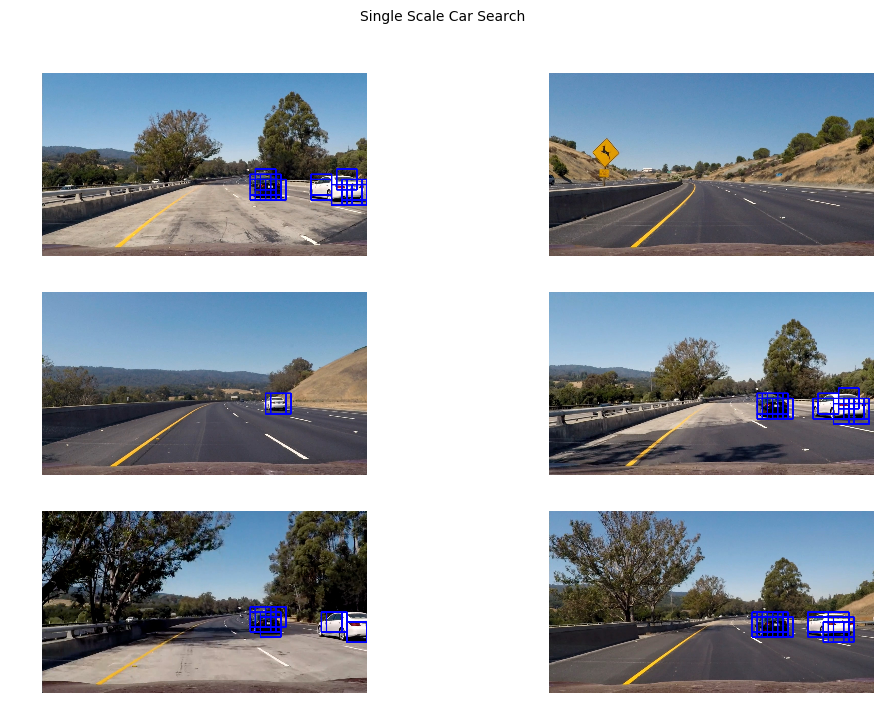

In [186]:
# Slide Window Parameters
x_start_stop = [None, None]
y_start_stop = [380, 625] 
xy_window = (80, 80) 
xy_overlap=(0.75, 0.75)

# Load test images
PATH = "test_images/"
test_images = os.listdir("test_images/")[1:]

# Grid for plotting
gs = gridspec.GridSpec(3,2)
plt.figure(figsize=(12,8)).suptitle("Single Scale Car Search")

# Car Search
for index, image_file in zip(range(0,6), test_images):
    test_image = read_image(PATH + image_file)
    
    # Extract Slide Window boxes
    window_boxes = slide_window(test_image, x_start_stop, y_start_stop, xy_window, xy_overlap)
    
    # Find hot Windows
    hot_windows = search_for_cars(test_image, window_boxes, svc, X_scaler, color_space, spatial_size, hist_bins, 
                   hist_range, orient, pix_per_cell, cell_per_block, hog_channel)
    # Plot Results
    plt.subplot(gs[index])
    plt.axis('off')
    plt.imshow(draw_boxes(test_image, hot_windows))

In the images above you can see a couple of false detection. You can also see that multiple windows detect the same vehicle. In the next step we will use a heatmap to draw a single bounding box for each vehicle and discard the false positives seen above.

#### A Note on Multiscale Window Search
Vehicles appear to be of different size depending on their distance from camera. In order to capture varying size vehicles without having to use different sizes of search windows, we can tweak the `xy_window` and the `xy_overlap` parameters. By selecting a relatively large window with high overlap percentage, the SVM is able to detect vehicles of different sizes robustly. The number of windows to be searched also decreases since we no longer need to generate slide windows of small, mid, or large size.

### Step 3: Outlier Removal
In order to remove outliers(false positives) from random frames, the hot windows will be used to build a heatmap such  that areas of multiple detections get "hot", while false positives stay "cool" and effectively remove the outlier.

To build a heatmap:
1. Create a matrix of zeros of the size of the image
2. Add 1 to each pixel location contained in each hot window
3. Threshold the heatmap to remove "cool" values

Once you have a thresholded heatmap, the `label()` function from `scipy.ndimage.measurements` will be used to count the number of vehicles in each frame and compute the size and location of each vehicle's bounding box.

To increase performance and deliver a smoother detection on video streams, the last n heatmaps will be stored for temporal purposes.

In [143]:
from scipy.ndimage.measurements import label

In [144]:
# Function to populate Heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Function to apply threshold to the heat map to discard cool zones - areas where vehicles are not present
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Function to draw a bounding box around the vehicles present in the heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

#### Test Heatmap

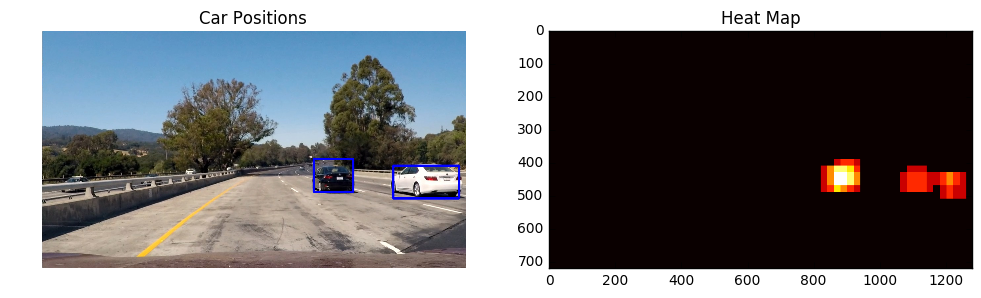

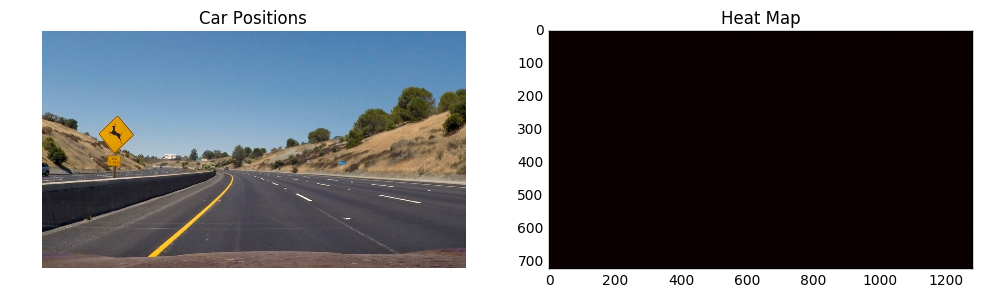

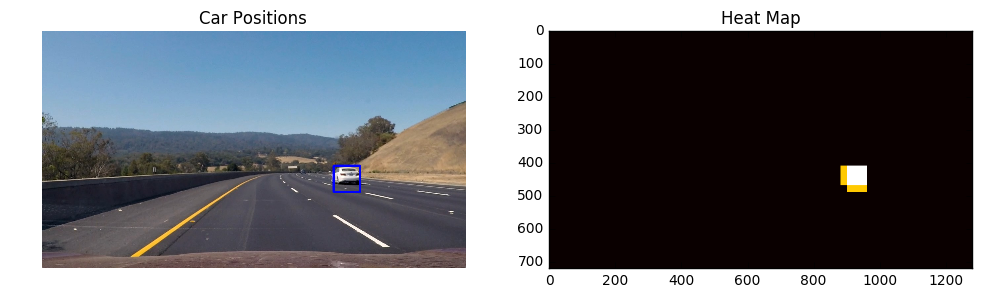

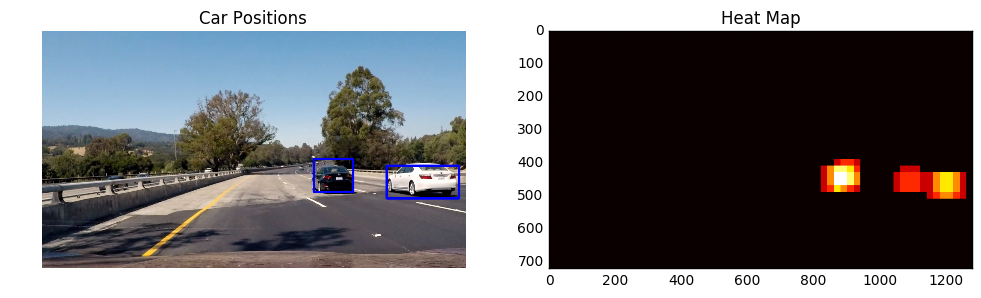

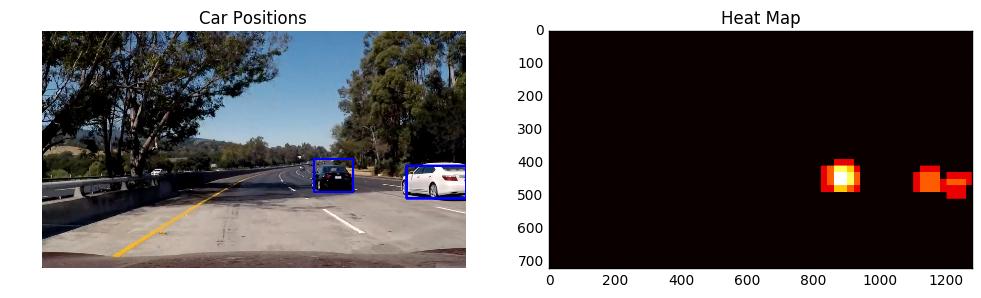

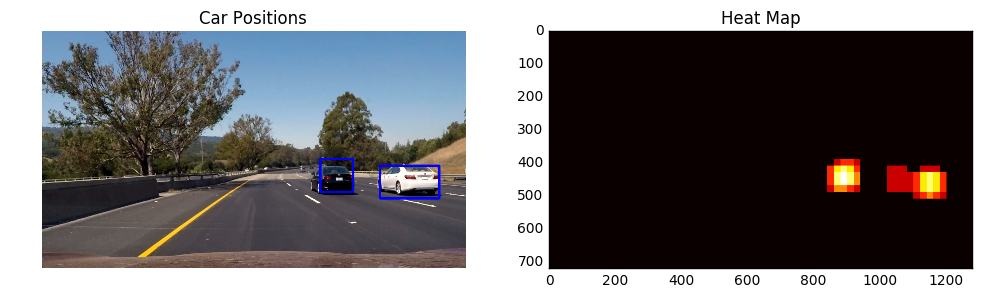

In [149]:
# Slide Window Parameters
x_start_stop = [None, None]
y_start_stop = [350, 625] 
xy_window = (80, 80) 
xy_overlap=(0.75, 0.75)

# Heatmap Parameters
heat_threshold = 1

for index, image_file in zip(range(0,6), test_images):
    test_image = read_image(PATH + image_file)
    
    # Extract Slide Window boxes
    window_boxes = slide_window(test_image, x_start_stop, y_start_stop, xy_window, xy_overlap)
    
    # Find hot Windows
    hot_windows = search_for_cars(test_image, window_boxes, svc, X_scaler, color_space, spatial_size, hist_bins, 
                   hist_range, orient, pix_per_cell, cell_per_block, hog_channel)
    
    # Initialize heatmap
    heatmap = np.zeros_like(test_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heatmap = add_heat(heatmap, hot_windows)
    
    # Apply threshold to remove false positives
    heatmap = apply_threshold(heatmap, heat_threshold)

    # Limit heatmap values to 255 for visualization purposes    
    heatmap = np.clip(heatmap, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    # Draw bounding boxes
    draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
    
    # Plot Results
    fig = plt.figure(figsize=(12,8))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')

---
## Part 5: Putting it All Together - Vehicle Detection and Tracking
The diagram below summarizes the pipeline flow to process image frames:

<img src="output_images/algo_diagram.png" style="width:600px;height:750px;">

#### Create a Heatmap Queue Class
Manages Heatmaps accross video frames to such that areas of multiple detections get "hot", while false positives stay "cool" and effectively remove the outlier. 

In [172]:
class HeatQueue:
    def __init__(self, limit):
        self._heat_frames = []
        self._queue_limit = limit
        self.queue_size = 0
        
    @property
    def queue_limit(self):
        return self._queue_limit
    
    @property
    def heat_frames(self):
        return self._heat_frames
      
    def enqueue(self, heatmap):
        self._heat_frames.insert(0, heatmap)
        if self.queue_size > self._queue_limit:
            self._dequeue()
        self.queue_size = len(self._heat_frames)

    def _dequeue(self):
        self._heat_frames.pop()
        self.queue_size = len(self._heat_frames)
        
    def sum_heat_frames(self):
        frames = np.array(self.heat_frames)
        return np.sum(frames, axis=0)

#### Process Image Pipeline

In [169]:
def process_frame(image, svc, scaler, heatmap_queue, 
                  cspace='RGB',
                  spatial_size=(32, 32), 
                  hist_bins=32, 
                  hist_range=(0, 256), 
                  orient=9,
                  pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                  x_start_stop=[None, None], 
                  y_start_stop=[None, None], 
                  xy_window=(64, 64), 
                  xy_overlap=(0.5, 0.5),
                  heat_threshold=1):
    
    # Extract sliding window boxes
    window_boxes = slide_window(image, x_start_stop, y_start_stop, xy_window, xy_overlap)
    
    # Find hot windows 
    hot_windows = search_for_cars(image, window_boxes, svc, X_scaler, color_space, spatial_size, hist_bins, 
                   hist_range, orient, pix_per_cell, cell_per_block, hog_channel)
    
    # Initialize heatmap
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to the pixels from each window in the hot window list
    heatmap = add_heat(heatmap, hot_windows)
    
    # Add current frame heatmap to the heatmap queue
    heatmap_queue.enqueue(heatmap)

    # Sum all heatmaps frames in the queue
    heatmap_queue_sum = heatmap_queue.sum_heat_frames()
    
    # Apply threshold to remove false positives
    heatmap_queue_sum = apply_threshold(heatmap_queue_sum, heat_threshold)

    # Find final boxes from heatmap using label function
    labels = label(heatmap_queue_sum)
       
    # Draw bounding boxes on vehicles
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

### Process Video Stream

In [188]:
# ============================================== 
#  Load Trained SVM and Feature Scalar
# ==============================================  
with open('svm_pickle.p', 'rb') as f:
    svm_params = pickle.load(f)
    svc = svm_params['svc']
    X_scaler = svm_params['scalar']

# ===============================================================
# Define Feature Extraction, Slide Window, and Heatmap Parameters
# ================================================================
parameters = { 
'cspace': 'YCrCb',           
'spatial_size': (32, 32), 
'hist_bins': 32, 
'hist_range': (0, 256), 
'orient': 9,
'pix_per_cell': 8, 
'cell_per_block': 2, 
'hog_channel': 'ALL',
'x_start_stop': [None, None], 
'y_start_stop': [380, 625], 
'xy_window': (80, 80), 
'xy_overlap': (0.75, 0.75),
'heat_threshold': 15
}

In [164]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
heatmap_queue = HeatQueue(25)   # Heatmap queue has 25 frames
output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(lambda frame: process_frame(frame, svc, X_scaler, heatmap_queue, **parameters))
test_clip = project_clip
%time test_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


  3%|▎         | 42/1261 [01:45<52:06,  2.56s/it]  